<a href="https://colab.research.google.com/github/Carvas91/PyTroch/blob/main/dropout_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

import seaborn as sns


<ipython-input-18-d65aa9ddf7ec>:8: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [16]:
iris = sns.load_dataset('iris')

data = torch.tensor(iris[iris.columns[0:4]].values).float()

labels = torch.zeros(len(data),dtype=torch.long)

labels[iris.species == 'versicolor'] = 1
labels[iris.species == 'virginica'] = 2

In [19]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=.2)

train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

batchsize = 16
trainloader = DataLoader(train_data, batch_size=batchsize, shuffle=True)
testloader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])


In [26]:
class ModelClass(nn.Module):
  def __init__(self, dropoutRate):
    super().__init__()

    self.input = nn.Linear(4,12)
    self.hidden = nn.Linear(12,12)
    self.output = nn.Linear(12,3)

    self.dr = dropoutRate

  def forward(self,x):
    x = F.relu(self.input(x))
    x = F.dropout(x, p=self.dr, training=self.training)

    x = F.relu(self.hidden(x))
    x = F.dropout(x,p=self.dr,training=self.training)

    x = self.output(x)
    return x

In [32]:
def createModel(dropoutRate):
  ANNiris = ModelClass(dropoutRate)

  lossfun = nn.CrossEntropyLoss()

  optimizer = torch.optim.SGD(ANNiris.parameters(), lr=0.01)

  return ANNiris, lossfun, optimizer

In [31]:


epochs = 500

def trainModel():
  trainAcc = []
  testAcc = []

  for i in range(epochs):
    ANNiris.train()

    batchAcc = []

    for X,y in trainloader:
      yHat = ANNiris(X)

      loss = lossfun(yHat,y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      batchAcc.append(torch.mean((torch.argmax(yHat, axis=1)==y).float()).item()*100)

    trainAcc.append(np.mean(batchAcc))

    ANNiris.eval()
    X,y = next(iter(testloader))

    predlabels = torch.argmax(ANNiris(X),axis=1)
    testAcc.append(torch.mean((predlabels == y).float()).item()*100)

  return trainAcc, testAcc


In [33]:
dr = 0

ANNiris, lossfun, optimizer = createModel(dr)

trainAcc, testAcc = trainModel()

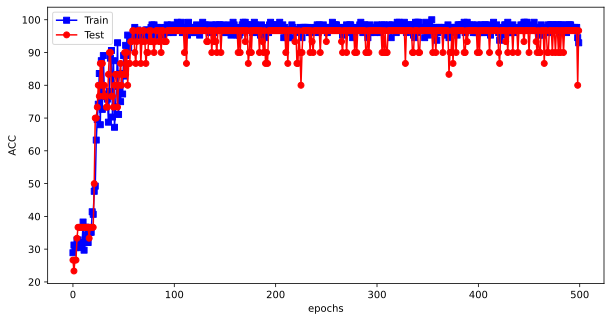

In [35]:
plt.figure(figsize=(10,5))
plt.plot(trainAcc, 'bs-')
plt.plot(testAcc, 'ro-')
plt.legend(['Train','Test'])
plt.xlabel('epochs')
plt.ylabel('ACC')
plt.show()

In [38]:
doRates = np.arange(10)/10

results = np.zeros((len(doRates),2))

for i in range(len(doRates)):
  ANNiris, lossfun, optimizer = createModel(doRates[i])
  trainAcc, testAcc = trainModel()
  results[i, 0] = np.mean(trainAcc[-50:])
  results[i,1] = np.mean(testAcc[-50:])

In [40]:
results

array([[97.390625  , 94.79999769],
       [94.578125  , 95.53333068],
       [90.265625  , 95.0666647 ],
       [87.75      , 96.53333056],
       [85.859375  , 95.59999776],
       [76.484375  , 95.33333123],
       [75.359375  , 94.39999831],
       [53.421875  , 75.59999967],
       [42.84375   , 64.39999926],
       [36.328125  , 27.60000134]])

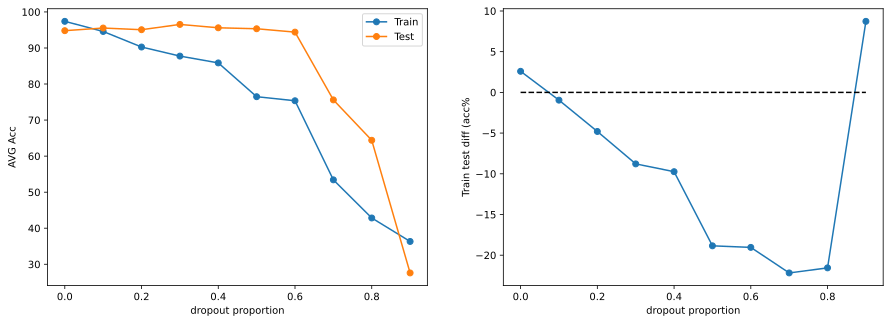

In [42]:
fig, ax = plt.subplots(1,2 ,figsize=(15,5))

ax[0].plot(doRates, results, 'o-')
ax[0].set_xlabel('dropout proportion')
ax[0].set_ylabel('AVG Acc')
ax[0].legend(['Train','Test'])


ax[1].plot(doRates, -np.diff(results,axis=1), 'o-')
ax[1].plot([0,.9],[0,0],'k--')
ax[1].set_xlabel('dropout proportion')
ax[1].set_ylabel('Train test diff (acc%')

plt.show()

